In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Parameters

In [5]:
# Set the random seed, so the experiment is reproducible
seed = 0
torch.manual_seed(seed)
# For the moment, we will just train on CPU, so no cuda
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
# We use a batch size of 32 examples while training, and 1000 while testing
batch_size = 32
test_batch_size = 1000
# We will use SGD with a momentum term
momentum = 0.5
# The learning rate
lr = 0.01
# The number of epochs
epochs = 3
# The size of the input. MNIST are greyscale images, 28x28 pixels each
im_size = 28*28

### Train

In [6]:
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())

### Test

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Load train and test data

In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

0it [00:00, ?it/s]

100%|█████████▉| 9895936/9912422 [00:19<00:00, 423161.73it/s] 

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 69020.27it/s]

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




  0%|          | 0/1648877 [00:00<?, ?it/s]

  0%|          | 8192/1648877 [00:01<01:18, 20933.71it/s]

  1%|          | 16384/1648877 [00:01<01:08, 23800.02it/s]

  2%|▏         | 32768/1648877 [00:01<00:53, 30458.66it/s]

  4%|▍         | 73728/1648877 [00:02<00:38, 40891.55it/s]

  7%|▋         | 114688/1648877 [00:02<00:28, 54004.14it/s]

  9%|▉         | 155648/1648877 [00:02<00:21, 68927.91it/s]

 12%|█▏        | 204800/1648877 [00:03<00:24, 59531.30it/s]

 13%|█▎        | 221184/1648877 [00:03<00:28, 50091.89it/s]

 16%|█▌        | 262144/1648877 [00:04<00:20, 67441.34it/s]

 18%|█▊        | 303104/1648877 [00:04<00:15, 87082.81it/s]

 20%|█▉        | 327680/1648877 [00:04<00:15, 87860.26it/s]

 22%|██▏       | 360448/1648877 [00:04<00:14, 87019.33it/s]

 23%|██▎       | 376832/1648877 [00:05<00:16, 76293.84it/s]

 26%|██▌       | 425984/1648877 [00:05<00:12, 100019.01it/s]

 29%|██▉       | 483328/1648877 [00:05<00:08, 130846.49it/s]

 31%|███▏      | 516096/1648877 [00:05<00

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




8192it [00:00, 26285.39it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!



9920512it [00:29, 423161.73it/s]                             
32768it [00:20, 69020.27it/s]                           

In [9]:
examples = enumerate(test_loader)
batch_idx, (example, label) = next(examples)
example.shape

torch.Size([1000, 1, 28, 28])

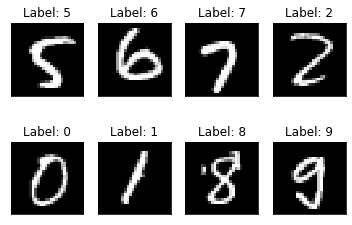

In [10]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(example[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Multilayer Perceptron

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
learning_rate = 0.01
momentum = 0.5
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [14]:
training_losses = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, training_losses)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.198369


/home/roi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.155087
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.131146
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.073608
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.029857
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.185125
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.241926
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.106881
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.092932
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.193102
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.114658
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.244189
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.172704
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.329610
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.275037
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.290272
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.215232
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.122801
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.076389

Test set: Average loss: 0.1198, Accuracy: 9648/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.09814